<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/master/bacterial_segmentaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/MahdiEsrafili/SegLoss.git

In [2]:
! pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
% cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d longnguyen2306/bacteria-detection-with-darkfield-microscopy

 97% 158M/162M [00:01<00:00, 127MB/s]
100% 162M/162M [00:01<00:00, 124MB/s]


In [4]:
!unzip -q bacteria-detection-with-darkfield-microscopy.zip -d data/

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import os
import random
from PIL import Image
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

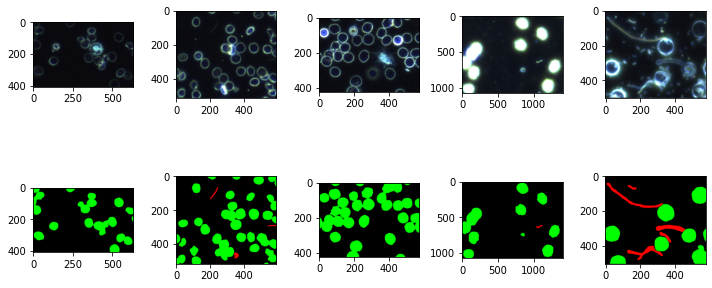

In [6]:
plt.figure(figsize=(10, 5))
idxs = np.random.randint(1, 366, size=5)
for n, i in enumerate(idxs):
  idx = '{:03}'.format(i)
  img = cv2.imread(f'data/images/{idx}.png')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  mask = cv2.imread(f'data/masks/{idx}.png')
  mask[:,:,0] = np.where(mask[:,:,0]==2, 255, mask[:,:,0])
  mask[:,:,1] = np.where(mask[:,:,1]==1, 255, mask[:,:,1])
  plt.subplot(2, 5, n+1)
  plt.imshow(img)
  plt.subplot(2, 5, 5+n+1)
  plt.imshow(mask)

plt.tight_layout()

In [7]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision import models
from tqdm.notebook import tqdm
import torchvision
import torch

In [8]:
img_dir = '/content/data/images'
files = os.listdir(img_dir)
random.shuffle(files)
train_test_ratio = 0.7
split_idx = int(len(files) * train_test_ratio)
train_id = files[:split_idx]
test_id = files[split_idx:]

In [9]:
# for f in files:
#   img = cv2.imread(f'/content/data/images/{f}')
#   print(img.shape)

In [10]:
train_id.__len__(), test_id.__len__()

(256, 110)

In [11]:
class BacterialDS(Dataset):
  def __init__(self, ids, path, transforms=None):
    self.ids = ids
    self.path = path
    self.transforms = transforms

  def __len__(self):
    return len(self.ids)
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.path, 'images', self.ids[idx])
    mask_path = os.path.join(self.path, 'masks', self.ids[idx])
    img = Image.open(img_path)
    mask = torchvision.io.read_image(mask_path)[0].unsqueeze(0)
    if self.transforms:
      img = self.transforms['image'](img)
      mask = self.transforms['mask'](mask)
    return img, mask

In [12]:
img_transforms = T.Compose([
                        T.Resize((480, 480)),
                        T.ToTensor()                        
])
mask_transforms = T.Compose([
                        T.Resize((480, 480)),                 
])
transforms = {
    'image' : img_transforms,
    'mask' : mask_transforms
}

In [13]:
path = '/content/data'
train_dataset = BacterialDS(train_id, path, transforms)
test_dataset = BacterialDS(test_id, path, transforms)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [46]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)

In [47]:
model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, 3)

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [49]:
model = model.train().to(device)

In [50]:
def train(model, optimizer, criterion, lr_scheduler, dataloaders, num_epochs=10):
  model.train()
  loss_history = list()
  num_epochs=10
  for epoch in range(num_epochs):
    pbar = tqdm(dataloaders['train'])
    epoch_losses = np.array([])
    for (images, masks) in pbar:
      images = images.to(device, dtype=torch.float)
      masks = masks.to(device, dtype=torch.long).view(-1, masks.size(2), masks.size(3))
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out['out'], masks)
      loss.backward()
      optimizer.step()
      epoch_losses = np.append(epoch_losses, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{num_epochs},\
                            loss= {epoch_losses.mean():.4f}')
    loss_history.append(epoch_losses.mean())
    lr_scheduler.step()
  return loss_history
      

In [51]:
from SegLoss.losses_pytorch import lovasz_loss


In [52]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# criterion = torch.nn.CrossEntropyLoss()
criterion = lovasz_loss.LovaszSoftmax()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [53]:
dataloaders = {'train': train_loader,
               'test': test_loader}

In [54]:
train(model, optimizer, criterion, lr_scheduler, dataloaders)

[0.5699611031450331,
 0.34650801587849855,
 0.31796603417024016,
 0.30355379823595285,
 0.2943583889864385,
 0.28282546368427575,
 0.2734381991904229,
 0.27079344470985234,
 0.2666418645530939,
 0.2601492383982986]

In [61]:
def test(model, dataloaders, criterion):
  with torch.no_grad():
    results = []
    ground_truth = []
    losses = np.array([])
    model.eval()
    for (images, masks) in dataloaders['test']:
      images = images.to(device)
      masks = masks.to(device)
      preds = model(images)
      results.append(preds['out'].cpu())
      loss = criterion(preds['out'], masks)
      losses = np.append(losses, loss.item())
    return results, losses

In [62]:
results, losses = test(model, dataloaders, criterion)

In [63]:
losses

array([0.31849614, 0.27799782, 0.26032495, 0.27629024, 0.26336965,
       0.26712573, 0.2480191 , 0.27262294, 0.26305217, 0.29991221,
       0.26993293, 0.29657355, 0.24525967, 0.2741518 , 0.31730339,
       0.51370561, 0.24989609, 0.24761616, 0.27712184, 0.25069767,
       0.26774853, 0.27407503, 0.25659221, 0.28994   , 0.29332826,
       0.24118409, 0.26404294, 0.26301065])

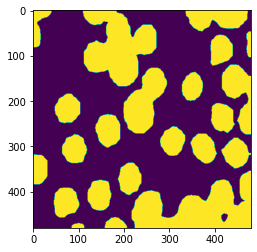

In [64]:
c = results[3][3]
cm = c.argmax(dim=0)
plt.imshow(cm)

In [65]:
with open('/content/model.pt', 'wb') as f:
  torch.save(model,f)

In [67]:
!ls -s /content/model.pt

164432 /content/model.pt


In [68]:
!cp /content/model.pt /content/drive/MyDrive/bacterial_segmentation/